# Transfer learning

Das Ziel des Transferlearning ist es, ein bereits trainiertes Modell auf eine andere Aufgabe zu trainieren. Die Idee dahinter ist den Teil des Netzwerks, der für die Extraktion von Merkmalen zuständig ist, zu "recyceln". Da dies in der Regel der teuerste Teil des Trainings ist, spart man sich dadurch eine Menge an Zeit. Das bedeutet, dass dieser Teil nicht neu trainiert werden muss, sondern die bereits trainierte Featurextraktion genauso gut für eine ähnliche Aufgabe verwendet werden kann. Aus diesem Grund sollte man ein bereits trainiertes Netzwerk nutzen, welches für eine ähnliche Aufgabe trainiert wurde. Lediglich die Klassifikationsschicht wird neu trainiert. Ziel dieses Notebooks ist es, ein Verständnis zu bekommen, was beim Transferlearning passiert.

Schauen Sie sich folgendes Notebook an und versuchen Sie den groben Ablauf zu verstehen.
Sie werden die meisten Befehle die Sie benötigen darin finden.
https://www.tensorflow.org/tutorials/images/transfer_learning

Für diese Aufgabe wollen wir das in der letzten Aufgabe trainierte Convolutional Neural Network, welches auf dem Mnist Datensatz trainiert wurde, auf eine andere Aufgabe trainieren. Die Aufgabe des Netzwerks soll es sein, zu entscheiden, ob eine Zahl größer oder kleiner als eine fixe Zahl ist.

Gehen Sie dazu wie folgt vor:

    * Laden Sie ihr Modell aus der vorherigen Aufgabe mit tf.keras.models.load_model("Name des Modells") Falls Sie ihr Modell nicht gespeichert hatten, können Sie dies mit model.save("Name des Modells"), nachdem Sie erneut trainiert haben, tun.
      
    * Bereiten Sie den Mnist-Datensatz wie in der vorherigen Aufgabe vor, und verändern Sie die Labels so, dass nur zwei Klassen existieren, >= 5 und <= 5
      
    * Laden Sie das zuvor gespeicherte Modell und entfernen Sie die letzte Schicht ( model.pop() )
    
    * Setzen Sie die Layer auf nicht trainierbar
    
    * Fügen Sie eine neue Schicht hinzu
    
    * Trainieren Sie das Netzwerk mit den transformierten Labels
    
    * Plotten Sie wieder die Trainingskurven und erstellen sie eine confusion Matrix

In [ ]:
#@author Reyhan Karamahmut

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
from keras.optimizers import Adam
from sklearn.metrics import confusion_matrix

from keras.datasets import mnist
import keras


In [3]:

# Vorbereiten von Mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()

# separate x_train in X_train and X_val, same for y_train
X_train=x_train[0:50000] / 255 #divide by 255 so that they are in range 0 to 1
Y_train=keras.utils.to_categorical(y_train[0:50000],10) # one-hot encoding

X_val=x_train[50000:60000] / 255
Y_val=keras.utils.to_categorical(y_train[50000:60000],10)

X_test=x_test / 255
Y_test=keras.utils.to_categorical(y_test,10)

del x_train, y_train, x_test, y_test

print(Y_train)



[[0. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]]


In [4]:

def relable(labels,threshold=5):
    
    relabled = []
    
    # Hier die transformation der Labels vornehmen
    # Zahl >= Threshold => [0,1] else: [1,0]
    for i in range(len(labels)):
        for j in range(len((labels[i]))):
            if labels[i][j] == 1:
                if j < threshold:
                    relabled.append([1,0])
                else: relabled.append([0,1])



    
    return np.array(relabled,dtype=np.float32)

Y_train_relabled = relable(Y_train)
Y_test_relabled = relable(Y_test)
print(X_train.shape)
print("original shape    :",Y_train.shape)
print("transformed shape :",Y_train_relabled.shape)


(50000, 28, 28)
original shape    : (50000, 10)
transformed shape : (50000, 2)


In [5]:
# Laden des Modells Modellnamen anpassen!
base_model = tf.keras.models.load_model("../exercise_2/CNN")
#Hier die letzte Schicht entfernen
base_model.pop()
base_model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 26, 26, 32)        320       
                                                                 
 activation_34 (Activation)  (None, 26, 26, 32)        0         
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 13, 13, 32)       0         
 2D)                                                             
                                                                 
 activation_35 (Activation)  (None, 13, 13, 32)        0         
                                                                 
 conv2d_10 (Conv2D)          (None, 11, 11, 64)        18496     
                                                                 
 activation_36 (Activation)  (None, 11, 11, 64)        0         
                                                      

In [6]:

# Hier Modell einfrieren
for layer in base_model.layers:
    layer.trainable =False

# Basismodell als Ausgangspunkt nehmen
inputs = tf.keras.Input(shape=(28, 28,1))
x = base_model(inputs, training=False)

# Hier ein Dense-layer hinzufügen sodass zwei Klassen vorhergesagt werden!
last_layer = tf.keras.layers.Dense(2)(x)
output     = tf.keras.layers.Activation('softmax')(last_layer)

# Modell Zusammenfügen
model = tf.keras.Model(inputs, output)



In [7]:
learning_rate = 1e-4
# Modell Kompilieren, Kostenfunktion categorical_crossentropy, Optimizer Adam mit der learningrate 1e-4
model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate),
              metrics=['accuracy']
              )
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 sequential_8 (Sequential)   (None, 10)                34826     
                                                                 
 dense (Dense)               (None, 2)                 22        
                                                                 
 activation (Activation)     (None, 2)                 0         
                                                                 
Total params: 34,848
Trainable params: 22
Non-trainable params: 34,826
_________________________________________________________________


In [8]:
loss0, accuracy0 = model.evaluate(x = X_test,y = Y_test_relabled)

313/313 [==============================] - 3s 8ms/step - loss: 7.8176 - accuracy: 0.3519


In [9]:
epochs = 2
# Hier das Netzwerk trainieren!
history=model.fit(X_train, Y_train_relabled,
                  batch_size=128,
                  epochs=epochs,
                  verbose=2,
                  validation_data=(X_val, relable(Y_val,5))
                  )


Epoch 1/2
391/391 - 10s - loss: 7.0680 - accuracy: 0.3685 - val_loss: 6.3991 - val_accuracy: 0.3788 - 10s/epoch - 26ms/step
Epoch 2/2
391/391 - 11s - loss: 5.5260 - accuracy: 0.4006 - val_loss: 4.8978 - val_accuracy: 0.4108 - 11s/epoch - 29ms/step


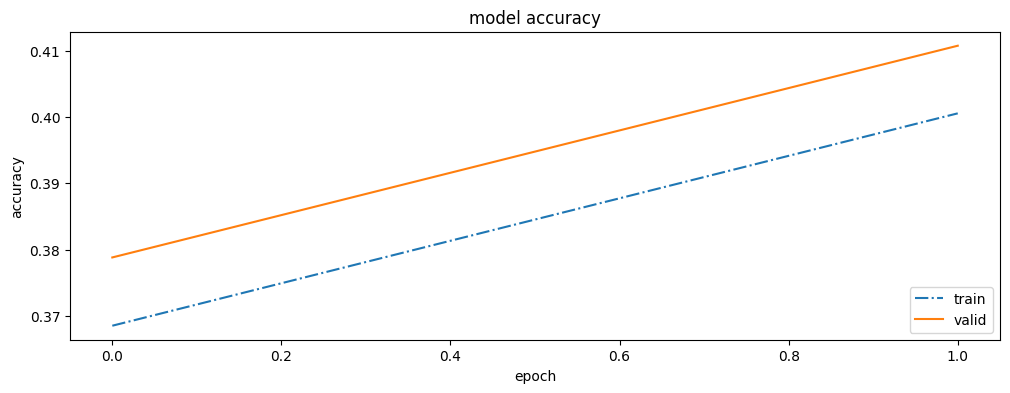

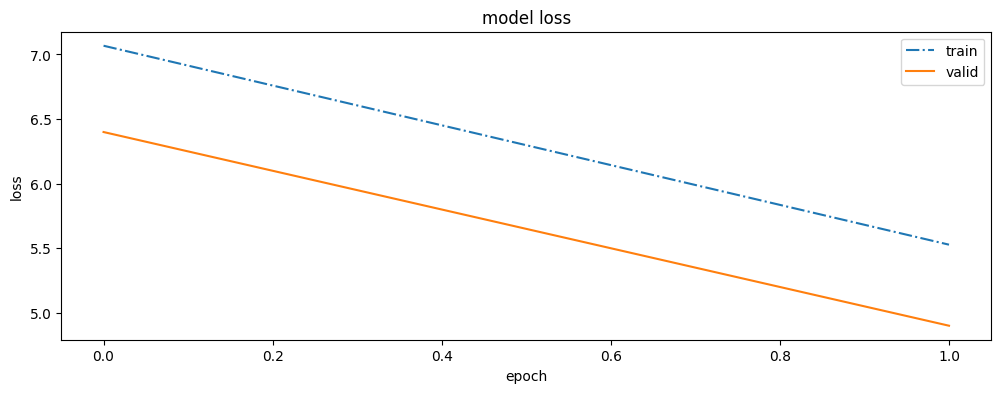

In [10]:

# Plotten Trainingskurve wie in der Aufgabe zuvor
#Accuracy Graph
plt.figure(figsize=(12,4))
plt.plot(history.history['accuracy'],linestyle='-.')
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='lower right')


#Loss Graph
plt.figure(figsize=(12,4))
plt.plot(history.history['loss'],linestyle='-.')
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper right')


In [11]:
# Confusion Matrix erstellen
pred=model.predict(X_test)
print(pred.shape)
print(confusion_matrix(np.argmax(Y_test_relabled,axis=1),np.argmax(pred,axis=1)))
acc_fc_orig = np.sum(np.argmax(Y_test_relabled,axis=1)==np.argmax(pred,axis=1))/len(pred)
print("Acc_fc_orig_flat = " , acc_fc_orig)

313/313 [==============================] - 3s 8ms/step
(10000, 2)
[[3201 1938]
 [3861 1000]]
Acc_fc_orig_flat =  0.4201
